In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
# Uncomment these to generate beautiful plots
# style.use('seaborn-poster')
# style.use('ggplot')
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
#import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.utils import plot_model
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [20]:
# Change this path to the directory of Dataset Directory
data_root = "./"
# Change the model_root to the directory of models saved
model_root = "../Deployment-Deep-Learning-Model/"

# Load The Pre-Trained Models
1. Conv 2D
2. VGG19
3. MobileNet V2
4. ResNet 50

In [3]:
MODEL_PATH_VGG = model_root + 'models/model_vgg19.h5'
MODEL_PATH_CONV2D = model_root + 'models/model_conv_2d.h5'
MODEL_PATH_MOBNETV2 = model_root + 'models/model_mobv2.h5'
MODEL_PATH_RESNET50 = model_root + 'models/model_resnet50.h5'
MODEL_PATH_INCEPTIONV3 = model_root + 'models/model_inceptionv3.h5'

# Load trained model
model_vgg = load_model(MODEL_PATH_VGG)
model_conv_2d = load_model(MODEL_PATH_CONV2D)
model_mobv2 = load_model(MODEL_PATH_MOBNETV2)
model_resnet50 = load_model(MODEL_PATH_RESNET50)
model_incep = load_model(MODEL_PATH_INCEPTIONV3)

In [4]:
# All the figures will be saved in this directory
if not os.path.exists('./Figures'):
    os.makedirs('./Figures')

# Instantiate Image Data Generators

In [5]:
train_gen = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1/255)

In [6]:
def getTrainTest(dims, batch_size):
    """
    This function returns the train generator and val generator for the models
        
         Parameters:
            dims (array or tuple): Dimension to resize the input images
            batch_size (int): Batch size for the data
        Returns:
            (train_generator, validation_generator)
    """
    DIMS = dims
    root = data_root
    train = train_gen.flow_from_directory(root + "RashData/Train/Train_2_Cases", target_size=(DIMS[0], DIMS[1]),
                                        batch_size=batch_size, class_mode='binary')
    val = val_gen.flow_from_directory(root + "RashData/Validation/Validation_2_Cases", target_size=(DIMS[0], DIMS[1]),
                                       batch_size=batch_size, class_mode='binary')
    return (train, val)

# Generate Confusion Matrix and Classification Report for a model 

In [26]:
def getConfusionMatrix(model, validation, batch_size, th=0.4, get_dict=True):
    """
    This Function returns the confusion matrix plot and classification report of the model
    
        Parameters:
            model : Keras Model
            validation: Validation generator
            batch_size (int): Batch size of the data
            th (float): thresold value if binary classifier
            get_dict (bool): True if classification report return type is dict and False if string
    """
    validation.reset()
    y_true = validation.classes
    
    Y_pred = model.predict_generator(validation, validation.n // batch_size + 1)
    if th != None:
        Y_pred = Y_pred > th
        Y_pred = Y_pred.astype('int')
        Y_pred = Y_pred[:,0]
        
    labels = ["Negative", "Positive"]
    conf_mat = confusion_matrix(y_true, Y_pred)
    class_report = classification_report(y_true, Y_pred, target_names=labels, output_dict=get_dict)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    
    return (disp, class_report)

# Plot different plots related to accuracy, auc and loss
##### Plots that are generated:
1. Plots of Training accuracy, Validation Accuracy vs Epochs
2. Plots of Training Loss, Validation Loss vs Epochs
3. Plots of Training AUC, Validation AUC vs Epochs
4. Plot of Confusion Matrix

In [8]:
def plot_train_val_accuracy(model, history, train, val, epoch, disp=None, save_name="unknown"):
    """
    This Function produces the plots for training accuracy, auc, loss
    and validation accuracy, auc, loss and saves them in provided location
    
        Parameters:
            model: Keras model
            history: keras model history object or saved history in dictionary or dataframe
            train: Train generator
            val: Validation generator
            epoch: No of epochs used to train the model
            disp: Confusion matrix plot
            save_name: Model Name in which the figure will be saved
    """
    train.reset()
    val.reset()
    
    if train != None and val != None:
        score_val = model.evaluate(val)
        score_train = model.evaluate(train)
        print('Test Loss:', score_val[0])
        print('Test accuracy:', score_val[1])
        print('Train Loss:', score_train[0])
        print('Train accuracy:', score_train[1])
        
    # For ROC 
    

    # plot accuracy
    
    epochs_range = range(1, epoch+1)
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    
    ax[0][0].plot(epochs_range, history['accuracy'])
    ax[0][0].plot(epochs_range, history['val_accuracy'])
    ax[0][0].set_title('Model Accuracy')
    ax[0][0].set_ylabel('Accuracy')
    ax[0][0].set_xlabel('Epoch')
    ax[0][0].legend(['Train Accuracy', 'Validation Accuracy'])
    
    if disp != None:
        disp.plot(ax=ax[0][1])
        disp.ax_.set_title("Confusion Matrix")
    
    ax[1][0].plot(epochs_range, history['loss'])
    ax[1][0].plot(epochs_range, history['val_loss'])
    ax[1][0].set_title('Model Loss')
    ax[1][0].set_ylabel('Loss')
    ax[1][0].set_xlabel('Epoch')
    ax[1][0].legend(['Train Loss', 'Validation Loss'])
    
    ax[1][1].plot(epochs_range, history['auc'])
    ax[1][1].plot(epochs_range, history['val_auc'])
    ax[1][1].set_title('Model AUC')
    ax[1][1].set_ylabel('AUC')
    ax[1][1].set_xlabel('Epoch')
    ax[1][1].legend(['Train AUC', 'Validation AUC'])
    
    fig.tight_layout(pad=3.0)
    fig.savefig('./Figures/' + save_name + ".png", bbox_inches='tight')

# Comparison Chart of Models
> All the models are compared on basis of different performance metrics

In [9]:
def plot_model_comparison(cr_list, model_names):
    """
    This function plots the different performance metrics for each class 
    for each models and saves the figures
    
        Parameters:
            cr_list (array): Array of classification reports of the models
            model_names (array): Array of model names
    """
    
    # We will save the f1 score, recalls and precision and support in following structure
    # curr_metric[class] = [cr_1.curr_metric, cr_2.curr_metric, ...]
    
    f1_scores = {}
    recalls = {}
    precisions = {}
    supports = {}
    
    for cls in ["Positive", "Negative"]:
        f1_scores[cls] = list([cr[cls]["f1-score"] for cr in cr_list])
        recalls[cls] = list([cr[cls]["recall"] for cr in cr_list])
        precisions[cls] = list([cr[cls]["precision"] for cr in cr_list])
        supports[cls] = list([cr[cls]["support"] for cr in cr_list])
        
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    X = np.arange(len(model_names))
    
    axes[0][0].bar(X, precisions["Positive"], color="crimson", width = 0.25)
    axes[0][0].bar(X + 0.25, precisions["Negative"], color="darkcyan", width=0.25)
    axes[0][0].set_title("Precision Comparison")
    axes[0][0].set_xlabel("Models")
    axes[0][0].set_ylabel("Precision")
    
    axes[0][1].bar(X, f1_scores["Positive"], color="crimson", width=0.25)
    axes[0][1].bar(X + 0.25, f1_scores["Negative"], color="darkcyan", width=0.25)
    axes[0][1].set_title("F1 Score Comparison")
    axes[0][1].set_xlabel("Models")
    axes[0][1].set_ylabel("f1 score")
    
    axes[1][0].bar(X, recalls["Positive"], color="crimson", width=0.25)
    axes[1][0].bar(X + 0.25, recalls["Negative"], color="darkcyan", width=0.25)
    axes[1][0].set_title("Recall Comparison")
    axes[1][0].set_xlabel("Models")
    axes[1][0].set_ylabel("recall")
    
    axes[1][1].bar(X, supports["Positive"], color="crimson", width=0.25)
    axes[1][1].bar(X + 0.25, supports["Negative"], color="darkcyan", width=0.25)
    axes[1][1].set_title("Support Comparison")
    axes[1][1].set_xlabel("Models")
    axes[1][1].set_ylabel("support")
    
    for i in range(2):
        for j in range(2):
            axes[i][j].set_xticks([i + 0.25 for i in range(len(model_names))], model_names)
            axes[i][j].legend(['Positive', 'Negative'])
            
    fig.tight_layout(pad=2.0)
    fig.savefig("./Figures/comparison.png", bbox_inches="tight")

# Plot intermediate outputs in a model

In [35]:
def plot_interm_act(classifier, no_of_layers, img_path, img_size, model_name=None):
    """
    Visualizes the intermediate outputs in a neural network model
        
        Parameters:
            classifier: tf.keras Model
            no_of_layers (int): Number of layers from top for which vizualisation is required
            img_path (str): Path of test image
            img_size (tuple): Requires dimension for input in classifier
            model_name (str): Name of the input classifier if any
            
        Returns:
            None
    """
    
    if model_name != None:
        print("Plotting first", no_of_layers, "of the", model_name, "model.")
    else:
        model_name = "unknown_model"
    
    path_to_save = ".Figures/Intermediate_activations/" + model_name
    
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
        print("Activation images will be saved in" + path_to_save)
        
    # Selecting first 'no_of_layers' no of layers from the classifier
    output_layers = [layer.output for layer in classifier.layers[:no_of_layers + 1]]
    
    # Defining the input layer
    input_layer = classifier.input
    # Instanciating the model
    model =  keras.Model(inputs=input_layer, outputs=output_layers)
    
    # Loading the image from the given image path
    ## Transforming the loaded image to array
    ### Expanding the dimensions -- Because Keras needs one extra dimension
    img = Image.load_img(img_path, target_size=img_size)
    img_tensor = Image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    
    # Plotting the three different color channels of the input image
    input_grid = np.zeros((img_size[0] * 1, img_size[0] * 3))
    input_grid[0:img_size[1], 0 * img_size[1]: 1 * img_size[1]] = img_tensor[0,:,:,0]
    input_grid[0:img_size[1], 1 * img_size[1]: 2 * img_size[1]] = img_tensor[0,:,:,1]
    input_grid[0:img_size[1], 2 * img_size[1]: 3 * img_size[1]] = img_tensor[0,:,:,2]    
    plt.title('input_layer')
    plt.imshow(input_grid)

    # Normalizing the values of the image tensor
    img_tensor /= 255.
    print("Shape of current resized image: ", img_tensor.shape)
    
    # Feeding the image tensor to the model and getting saving outputs of each layer in 'activations'
    activations = model.predict(img_tensor)
    
    # Saving the corresponding layer names for plotting
    layer_names = list([layer.name for layer in classifier.layers[:no_of_layers+1]])
    
    # Iterating through all layers
    for layer_name, activation in zip(layer_names, activations):
        plots_per_row = 16 # No of channels to be plotted in each row
        
        no_of_channels = activation.shape[-1] # No of channels in current output layer
        
        # If current no of channels is less than 'plots_per_row'
        if no_of_channels < plots_per_row:
            plots_per_row = no_of_channels
        
        # Size of the current output -- no_of_cols == no_of_row in output
        size = activation.shape[1]
        
        # No of row's required
        no_row = no_of_channels // plots_per_row
        
        # Defining a grid in which all channels of current layer is concatenated
        grid = np.zeros((size * no_row, plots_per_row * size))
    
        for i in range(no_row):
            for j in range(plots_per_row):
                channel_img = activation[0,:,:,i * plots_per_row + j]
                
                # Normalizing the image
                channel_img -= channel_img.mean()
                channel_img /= channel_img.std()
                channel_img *= 64
                channel_img += 128
                channel_img = np.clip(channel_img, 0, 255).astype('uint8')
            
                # Adding the current channel to the grid
                grid[i * size:(i + 1) * size, j * size:(j + 1) * size] = channel_img
        
        # Scaling the current grid
        scale = 1 / size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.imshow(grid, aspect='auto')
        plt.title(layer_name)
#         plt.grid(b=None)
        plt.savefig(path_to_save + '/' + layer_name + '.png', bbox_inches='tight')

# Plotting the Grad-CAM figures 
> Grad-CAM figures help us to observe the main area where the model is concentrating

In [16]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = Image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = Image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array /= 255.
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, name="cam", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    plt.subplot(1, 2, 1)
    plt.grid(b=None)
    plt.imshow(img)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.grid(b=None)
    plt.savefig("./Figures/" + name + ".png", bbox_inches='tight')
#     superimposed_img.save(cam_path)

In [17]:
# Load lOG FILES

# Change root_log according to the directory of logs folder
root_log = ''
hist_conv2d = pd.read_csv(root_log + './logs/conv2d.csv')
hist_vgg19 = pd.read_csv(root_log + './logs/vgg19.csv')
hist_mobnet = pd.read_csv(root_log + './logs/mobnetv2.csv')
hist_resnet = pd.read_csv(root_log + './logs/resnet50.csv')
hist_incep = pd.read_csv(root_log + './logs/inceptionv3.csv')
display(hist_mobnet)

epoch  accuracy       auc      loss            lr  val_accuracy   val_auc  \
0       0  0.621777  0.681896  1.411218  1.000000e-03        0.6500  0.769826   
1       1  0.799427  0.875276  0.481282  1.000000e-03        0.6500  0.782227   
2       2  0.862464  0.937248  0.316063  1.000000e-03        0.8125  0.870844   
3       3  0.885387  0.943104  0.296603  1.000000e-03        0.7625  0.875651   
4       4  0.891117  0.953492  0.270725  1.000000e-03        0.7250  0.851237   
..    ...       ...       ...       ...           ...           ...       ...   
95     95  0.982808  0.997559  0.053022  5.000000e-07        0.8125  0.897059   
96     96  0.994269  0.999797  0.029803  5.000000e-07        0.7875  0.914571   
97     97  0.974212  0.996856  0.077140  5.000000e-07        0.7750  0.867619   
98     98  0.988539  0.999613  0.040315  5.000000e-07        0.8250  0.911025   
99     99  0.974212  0.997672  0.070133  5.000000e-07        0.7750  0.874597   

    val_loss  
0   2.420440  
1   1.195369  
2   0.588501  
3   0.728346  
4   0.614173  
..       ...  
95  0.528117  
96  0.456017  
97  0.614715  
98  0.437366  
99  0.662235  

[100 rows x 8 columns]

In [18]:
test_img_path = "./RashData/Lyme_Positive_By_Diease/EMRash/erythema migrans42.jpg"

Found 357 images belonging to 2 classes.
Found 87 images belonging to 2 classes.
Found 357 images belonging to 2 classes.
Found 87 images belonging to 2 classes.
36/36 [==============================] - 19s 534ms/step - loss: 0.0087 - accuracy: 1.0000 - auc: 1.0000
Test Loss: 0.5705171823501587
Test accuracy: 0.7931034564971924
Train Loss: 0.008677271194756031
Train accuracy: 1.0
36/36 [==============================] - 28s 782ms/step - loss: 1.5598 - accuracy: 1.0000 - auc: 1.0000
Test Loss: 2.5527520179748535
Test accuracy: 0.7126436829566956
Train Loss: 1.55984628200531
Train accuracy: 1.0
36/36 [==============================] - 45s 1s/step - loss: 0.6808 - accuracy: 0.5770 - auc: 0.5120
Test Loss: 0.6754839420318604
Test accuracy: 0.5862069129943848
Train Loss: 0.6807848215103149
Train accuracy: 0.5770308375358582
36/36 [==============================] - 33s 911ms/step - loss: 0.6920 - accuracy: 1.0000 - auc: 1.0000
Test Loss: 1.3553909063339233
Test accuracy: 0.7931034564971924
T

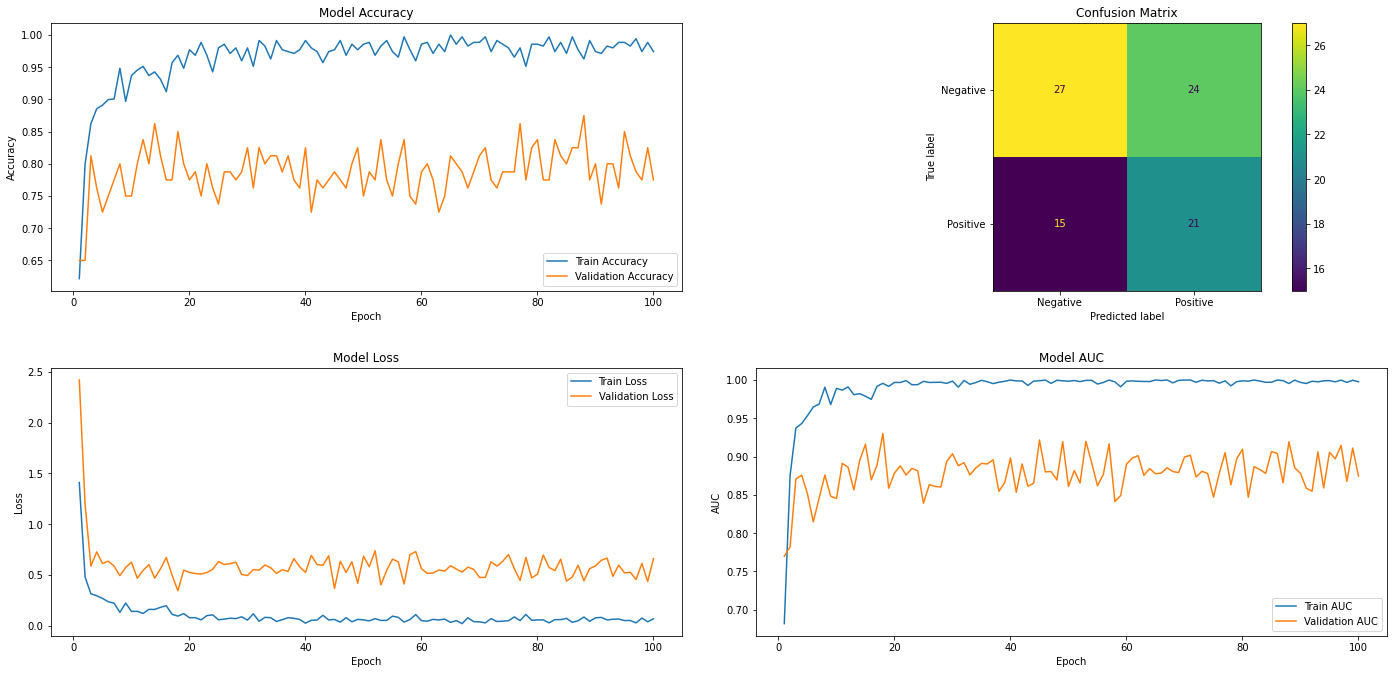

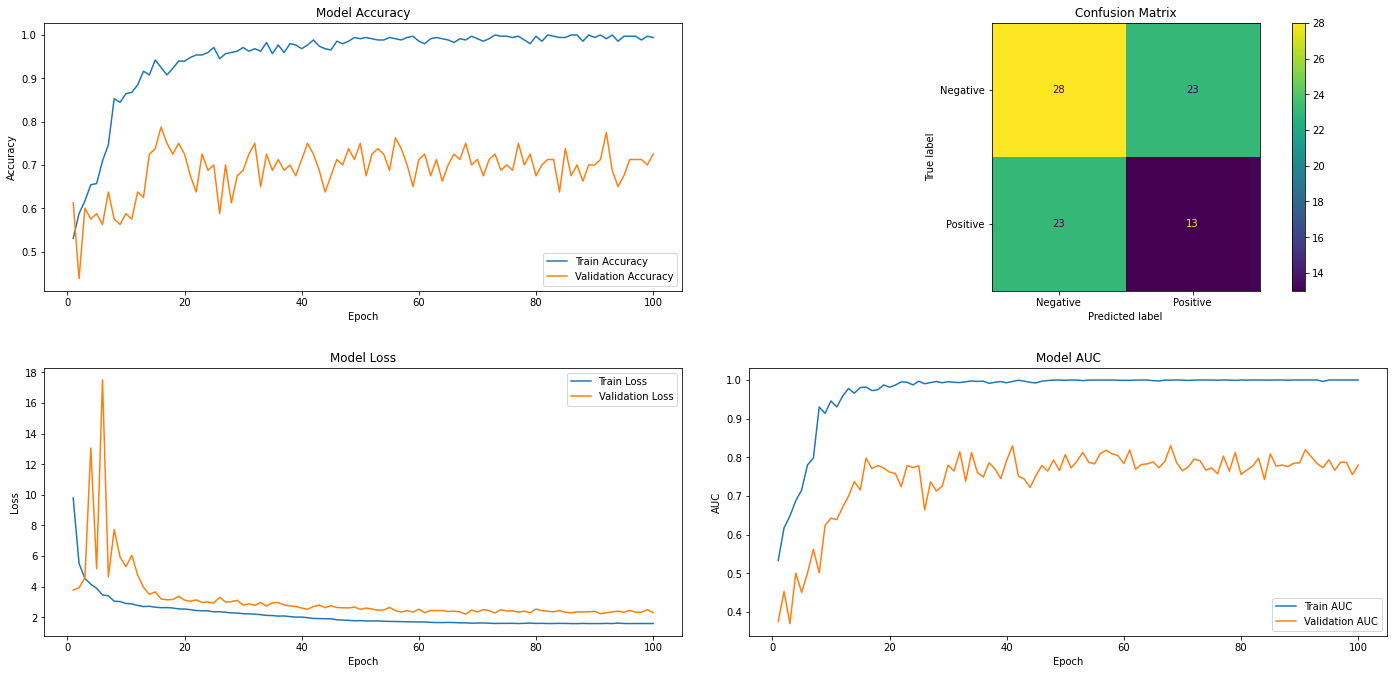

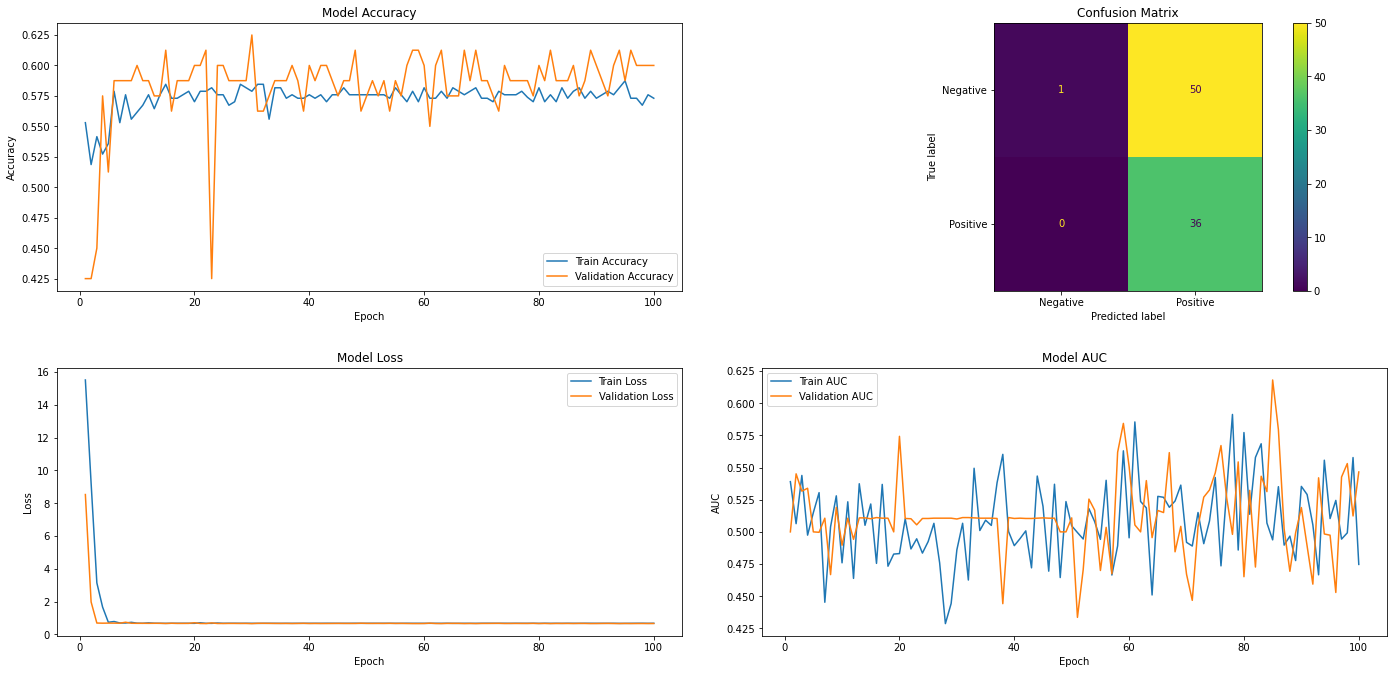

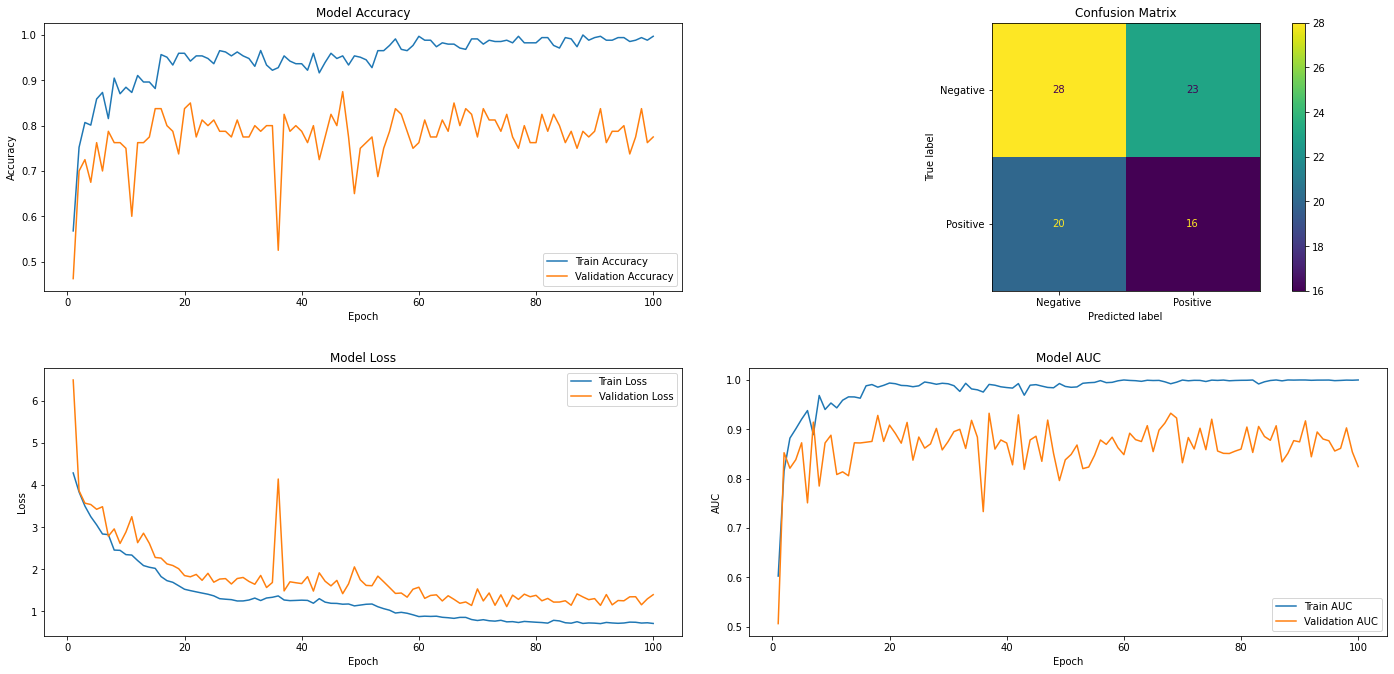

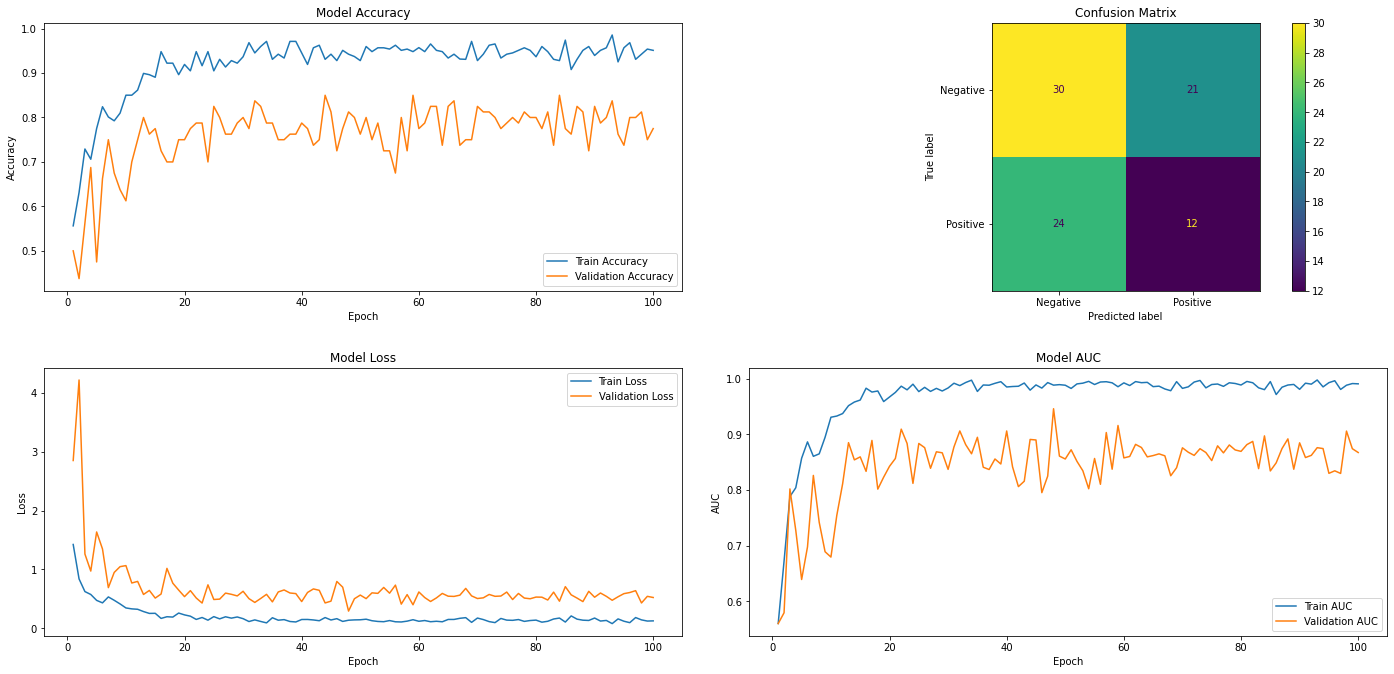

In [28]:
# Generating the train and validation generators for Conv2D(Where input image size = (300 * 300 * 3))
# And other state of the art models where input size = 224 * 224 * 3
train, val = getTrainTest((224, 224, 3), 10)
train_conv, val_conv = getTrainTest((300, 300, 3), 10)

disp_mobnet, cr_mobnet = getConfusionMatrix(model_mobv2, val, 10)
plot_train_val_accuracy(model_mobv2, hist_mobnet, train, val, 100, disp=disp_mobnet, save_name="MobileNetV2")

disp_conv, cr_conv = getConfusionMatrix(model_conv_2d, val_conv, 10)
plot_train_val_accuracy(model_conv_2d, hist_conv2d, train_conv, val_conv, 100, disp=disp_conv, save_name="CONV2D")

disp_resnet, cr_resnet = getConfusionMatrix(model_resnet50, val, 10)
plot_train_val_accuracy(model_resnet50, hist_resnet, train, val, 100, disp=disp_resnet, save_name="ResNet50")

disp_incep, cr_incep = getConfusionMatrix(model_incep, val, 10)
plot_train_val_accuracy(model_incep, hist_incep, train, val, 100, disp=disp_incep, save_name="InceptionV3")

disp_vgg, cr_vgg = getConfusionMatrix(model_vgg, val, 10)
plot_train_val_accuracy(model_vgg, hist_vgg19, train, val, 100, disp=disp_vgg, save_name="VGG19")

In [29]:
model_names = ["MobileNetV2", "VGG19", "Conv2D", "ResNet50", "InceptionV3"]

# Saving the classification report of each model in the array 
cr_list = [cr_mobnet, cr_vgg, cr_conv, cr_resnet, cr_incep]

In [30]:
# for i in range(len(cr_list)):
#     print("=============================================")
#     print(model_names[i])
#     print(cr_list[i])

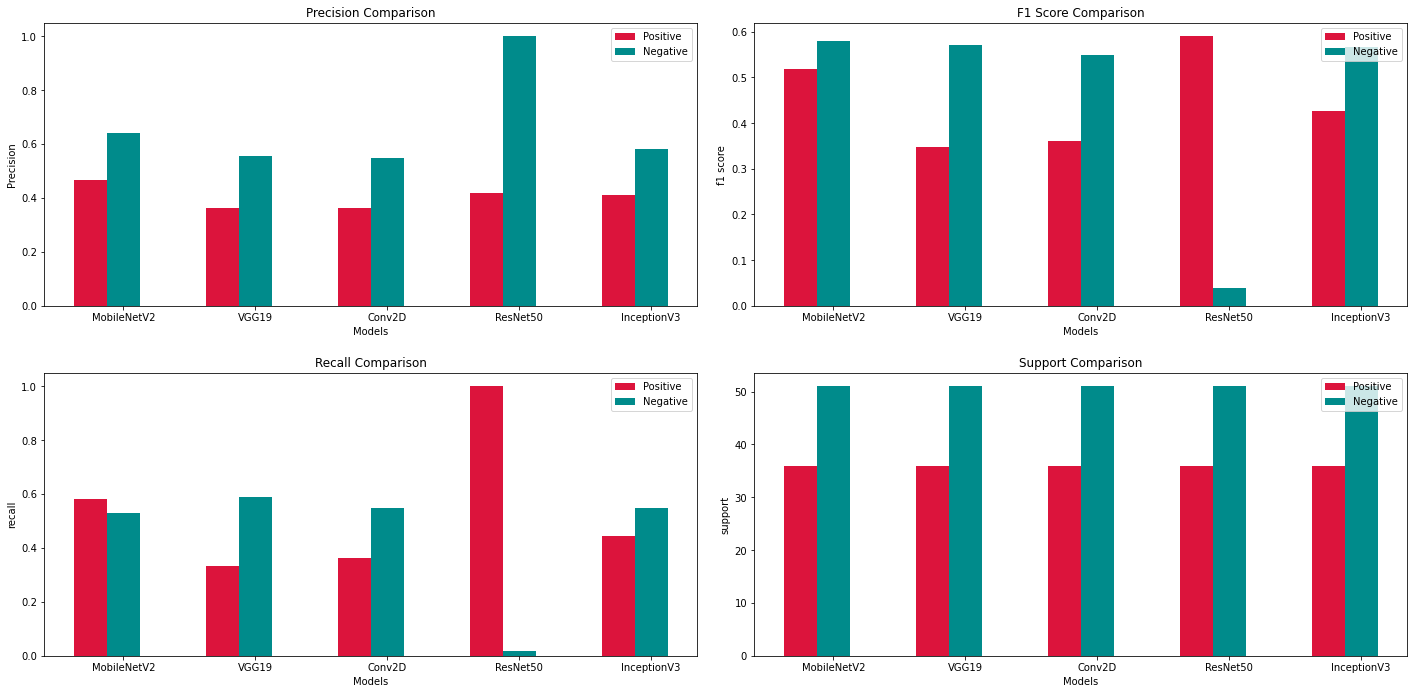

In [31]:
plot_model_comparison(cr_list, model_names)

Plotting first 5 of the VGG19 model.
Shape of current resized image:  (1, 224, 224, 3)


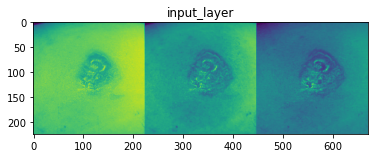

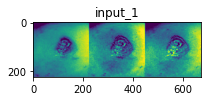

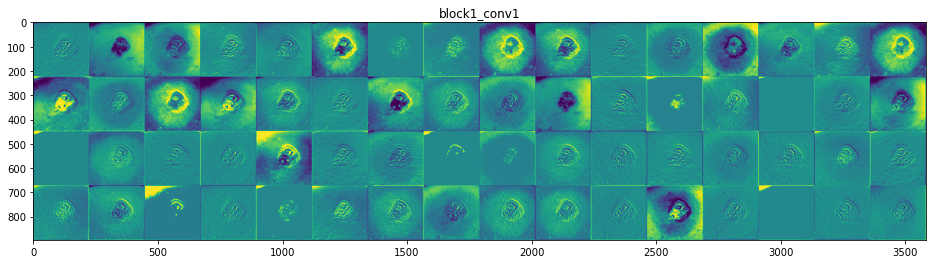

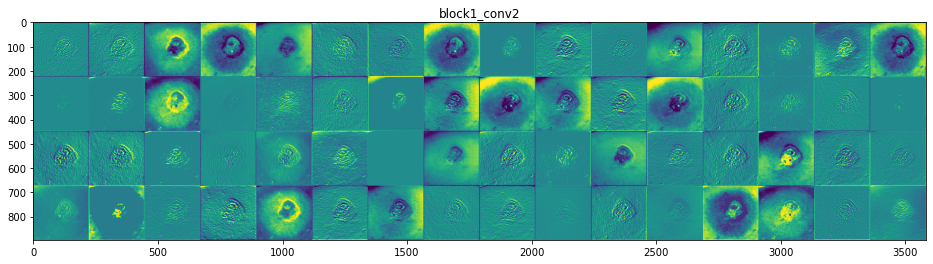

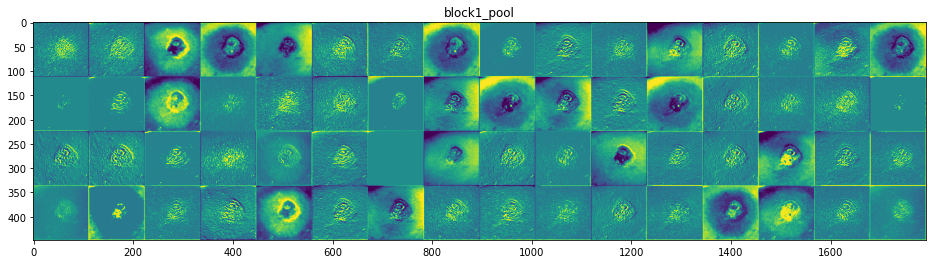

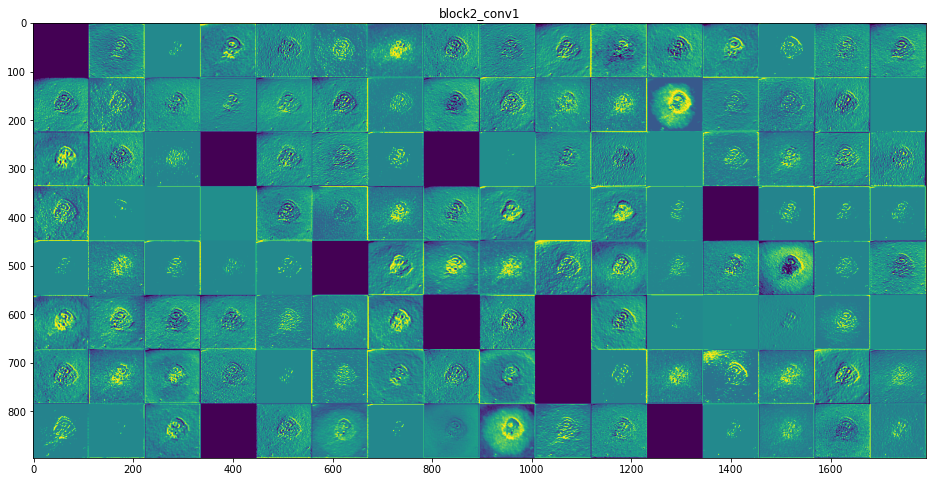

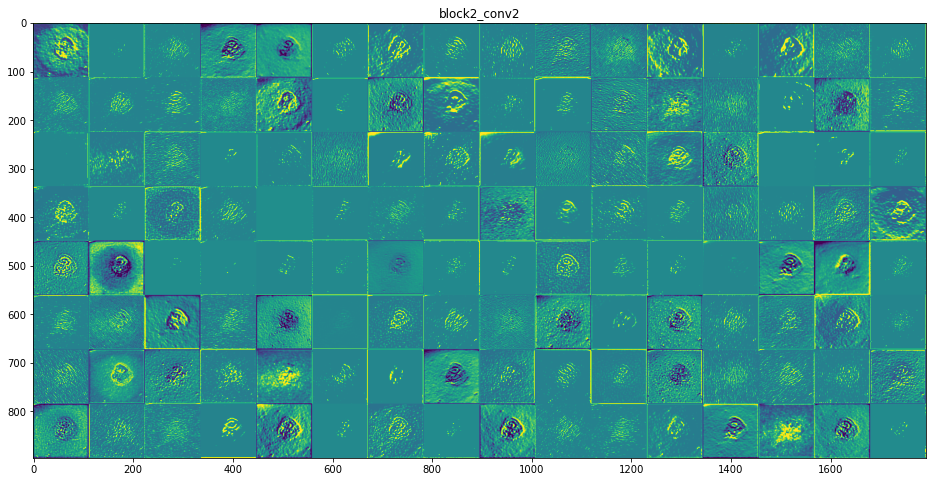

In [37]:
# Lets observe first 12 layer outputs of VGG19 Models
plot_interm_act(model_vgg, 5, test_img_path, (224, 224, 3), model_name="VGG19")

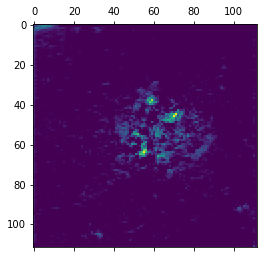

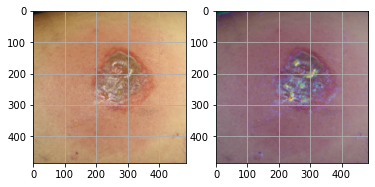

In [45]:
# Plotting Grad-CAM of second conv layer of VGG19
last_conv_layer_name = "block2_conv2"
img_size = (224, 224)
img_array = get_img_array(test_img_path, size=img_size)
heatmap = make_gradcam_heatmap(img_array, model_vgg, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(test_img_path, heatmap, name='VGG19_b2_c2')

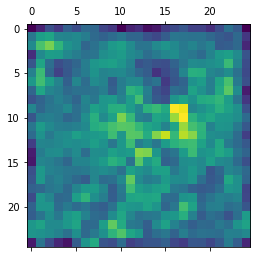

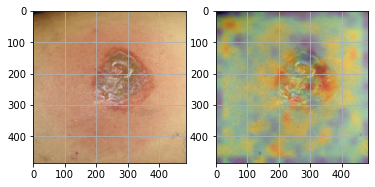

In [46]:
# Plotting Grad-CAM of 15th conv layer of Inception V3
last_conv_layer_name = "conv2d_15"
img_size = (224, 224)
img_array = get_img_array(test_img_path, size=img_size)
heatmap = make_gradcam_heatmap(img_array, model_incep, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(test_img_path, heatmap, name='incep_con_15')

In [47]:
# Prepare image
# img_array = model_vgg.preprocess_input(get_img_array(img_path, size=img_size))
# # Make model
# model = model_builder(weights="imagenet")

# # Remove last layer's softmax
# model.layers[-1].activation = None

# # Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap

# Display heatmap


In [56]:
## Roc Curve
def plot_roc_curve(model_list, model_names, val):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].plot([0, 1], [0, 1], 'k--')
    for i in range(len(model_names)):
        model = model_list[i]
#         val.reset()
        y_pred = model.predict(val, val.n // val.batch_size + 1).ravel()
#         y_pred = y_pred > 0.4
#         y_pred = y_pred.astype('int')
#         y_pred = y_pred[:,0]
        fpr, tpr, th = roc_curve(val.classes, y_pred)
        auc_curr = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, label='{} (area = {:.3f})'.format(model_names[i], auc_curr))
    axes[0].set_xlabel('False positive rate')
    axes[0].set_ylabel('True positive rate')
    axes[0].legend(model_names)
    plt.show()

In [57]:
model_list = [model_mobv2, model_vgg, model_conv_2d, model_resnet50, model_incep]

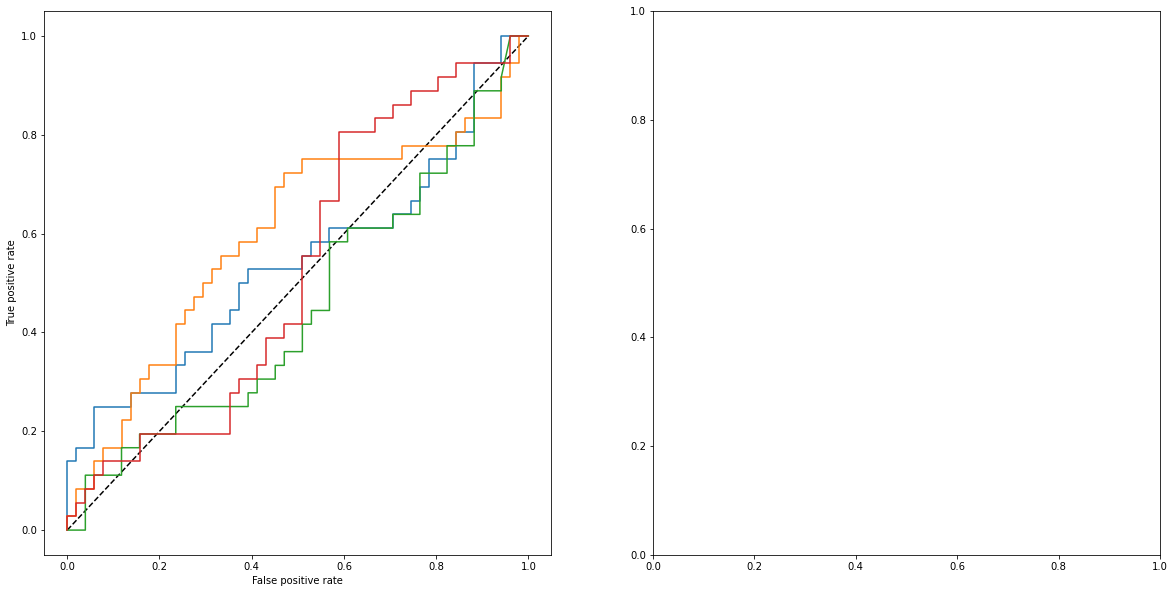

In [60]:
plot_roc_curve(model_list[0:2] + model_list[3:], model_names[0:2] + model_names[3:], val)

In [4]:
def get_table(hist):
    hist_new = hist.copy()
    hist_new['accuracy'] = hist['accuracy'] * 100
    hist_new['val_accuracy'] = hist['val_accuracy'] * 100
    hist_new.drop('lr', axis=1, inplace=True)
    hist_new.drop('epoch', axis=1, inplace=True)
    display(hist_new.iloc[::10])
    display(hist_new.tail(1))

In [5]:
get_table(hist_resnet)

accuracy       auc       loss  val_accuracy   val_auc  val_loss
0   55.300862  0.539013  15.512531     42.500001  0.500000  8.529478
10  56.733525  0.523363   0.682427     58.749998  0.510638  0.680166
20  57.879657  0.510088   0.712948     60.000002  0.510417  0.669823
30  58.452719  0.506681   0.677869     56.250000  0.511111  0.680284
40  57.306588  0.494748   0.681335     58.749998  0.510638  0.672440
50  57.593125  0.499479   0.682022     58.749998  0.433591  0.672844
60  57.306588  0.585401   0.680665     55.000001  0.505366  0.689135
70  57.306588  0.489010   0.683384     58.749998  0.446809  0.672967
80  57.020056  0.513674   0.683780     58.749998  0.532237  0.672785
90  57.593125  0.529027   0.680783     58.749998  0.489039  0.672470

accuracy       auc     loss  val_accuracy   val_auc  val_loss
99  57.306588  0.474732  0.68284     60.000002  0.546549   0.66878